<a href="https://colab.research.google.com/github/KORALLLL/MTUCI_EMNIST/blob/Sasha/ColabFiles/DropOutBatchExperiments_week_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as bar
import pickle
import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
!git clone https://github.com/KORALLLL/MTUCI_EMNIST.git

Cloning into 'MTUCI_EMNIST'...
remote: Enumerating objects: 36607, done.
remote: Counting objects: 100% (12967/12967), done.
remote: Compressing objects: 100% (12794/12794), done.
remote: Total 36607 (delta 263), reused 12808 (delta 160), pack-reused 23640
Receiving objects: 100% (36607/36607), 132.60 MiB | 5.17 MiB/s, done.
Resolving deltas: 100% (548/548), done.


In [3]:
emnist_train = torchvision.datasets.EMNIST('./', split='letters', download = True, train = True)
mnist_train = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = True)
emnist_val = torchvision.datasets.EMNIST('./', split='letters', download = True, train = False)
mnist_val = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

emnist_train_data = emnist_train.data
mnist_train_data = mnist_train.data
train_data = torch.cat([emnist_train_data[:24960], mnist_train_data[:12000]], dim=0).float().unsqueeze(1).to(device) / 255

emnist_val_data = emnist_val.data
mnist_val_data = mnist_val.data
val_data = torch.cat([emnist_val_data, mnist_val_data], dim=0).float().unsqueeze(1).to(device) / 255

temp_emnist_train_labels = emnist_train.targets[:24960]
emnist_train_labels = []

temp_emnist_val_labels = emnist_val.targets
emnist_val_labels = []

for i in range(len(temp_emnist_train_labels)):
  if temp_emnist_train_labels[i]==15:
    emnist_train_labels.append(torch.tensor(0))
  elif temp_emnist_train_labels[i]>15:
    emnist_train_labels.append(temp_emnist_train_labels[i]+8)
  else:
    emnist_train_labels.append(temp_emnist_train_labels[i]+9)

for i in range(len(temp_emnist_val_labels)):
  if temp_emnist_val_labels[i]==15:
    emnist_val_labels.append(torch.tensor(0))
  elif temp_emnist_val_labels[i]>15:
    emnist_val_labels.append(temp_emnist_val_labels[i] + 8)
  else:
    emnist_val_labels.append(temp_emnist_val_labels[i]+9)

mnist_train_labels = mnist_train.targets
train_labels = torch.cat([torch.stack(emnist_train_labels[:24960]), mnist_train_labels[:12000]], dim=0).to(device)

mnist_val_labels = mnist_val.targets
val_labels = torch.cat([torch.stack(emnist_val_labels), mnist_val_labels], dim=0).to(device)


file = open('MTUCI_EMNIST/dataset.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

test_data = test_dataset['data'].numpy()
test_data = np.flip(test_data, axis = 3)
test_data = np.rot90(test_data, k=1, axes=(2,3))
test_data = 1 - test_data
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = test_dataset['targets'].to(device)


100%|██████████| 561753746/561753746 [00:29<00:00, 18765021.43it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


##Лучшая сеть по итогам экспериментов


In [4]:
class LeNetSkipConnection(torch.nn.Module):
  def __init__(self):
    super(LeNetSkipConnection, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=1)
    self.act1 = torch.nn.ReLU6()
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=1)

    self.act2 = torch.nn.ReLU6()
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    self.act3 = torch.nn.ReLU6()
    self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act4 = torch.nn.ReLU6()

    self.conv5 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act5 = torch.nn.ReLU6()

    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.act6 = torch.nn.ReLU6()


    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act7 = torch.nn.ReLU6()
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act8 = torch.nn.ReLU6()
    self.conv8 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act9 = torch.nn.ReLU6()
    self.conv9 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.act10 = torch.nn.ReLU6()
    self.conv10 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.act11 = torch.nn.ReLU6()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act12 = torch.nn.ReLU6()

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act13 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act14 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.act2(x)
    x = self.conv3(x)
    x = self.act3(x)
    x = self.conv4(x)
    x = self.act4(x)
    skip_connection_1 = x
    x = self.conv5(x)
    x = self.act5(x)
    x = torch.add(x, skip_connection_1)
    x = self.pool1(x)
    x = self.act6(x)

    x = self.conv6(x)
    x = self.act7(x)
    x = self.conv7(x)
    x = self.act8(x)
    x = self.conv8(x)
    x = self.act9(x)
    x = self.conv9(x)
    x = self.act10(x)
    x = self.conv10(x)
    x = self.act11(x)
    x = self.pool2(x)
    x = self.act12(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act13(x)
    x = self.fc2(x)
    x = self.act14(x)
    x = self.fc3(x)

    return x


##Добавление слоев батч-нормализации

In [5]:
class LeNetBatch(torch.nn.Module):
  def __init__(self):
    super(LeNetBatch, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=1)
    self.batch_norm1 = torch.nn.BatchNorm2d(2)
    self.act1 = torch.nn.ReLU6()
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=1)
    self.batch_norm2 = torch.nn.BatchNorm2d(4)

    self.act2 = torch.nn.ReLU6()
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    self.batch_norm3 = torch.nn.BatchNorm2d(8)
    self.act3 = torch.nn.ReLU6()
    self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm4 = torch.nn.BatchNorm2d(16)
    self.act4 = torch.nn.ReLU6()
    self.conv5 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm5 = torch.nn.BatchNorm2d(16)
    self.act5 = torch.nn.ReLU6()
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.act6 = torch.nn.ReLU6()


    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm6 = torch.nn.BatchNorm2d(16)
    self.act7 = torch.nn.ReLU6()
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm7 = torch.nn.BatchNorm2d(16)
    self.act8 = torch.nn.ReLU6()
    self.conv8 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm8 = torch.nn.BatchNorm2d(16)
    self.act9 = torch.nn.ReLU6()
    self.conv9 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.batch_norm9 = torch.nn.BatchNorm2d(16)
    self.act10 = torch.nn.ReLU6()
    self.conv10 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.batch_norm10 = torch.nn.BatchNorm2d(16)
    self.act11 = torch.nn.ReLU6()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act12 = torch.nn.ReLU6()

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act13 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act14 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.act2(x)
    x = self.conv3(x)
    x = self.batch_norm3(x)
    x = self.act3(x)
    x = self.conv4(x)
    x = self.batch_norm4(x)
    x = self.act4(x)
    skip_connection_1 = x
    x = self.conv5(x)
    x = self.batch_norm5(x)
    x = self.act5(x)
    x = torch.add(x, skip_connection_1)
    x = self.pool1(x)
    x = self.act6(x)

    x = self.conv6(x)
    x = self.batch_norm6(x)
    x = self.act7(x)
    x = self.conv7(x)
    x = self.batch_norm7(x)
    x = self.act8(x)
    x = self.conv8(x)
    x = self.batch_norm8(x)
    x = self.act9(x)
    x = self.conv9(x)
    x = self.batch_norm9(x)
    x = self.act10(x)
    x = self.conv10(x)
    x = self.batch_norm10(x)
    x = self.act11(x)
    x = self.pool2(x)
    x = self.act12(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act13(x)
    x = self.fc2(x)
    x = self.act14(x)
    x = self.fc3(x)

    return x


##Добавление дропаута

In [6]:
class LeNetDropOut(torch.nn.Module):
  def __init__(self, dropout_rate):
    super(LeNetDropOut, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=1)
    self.act1 = torch.nn.ReLU6()
    self.dropout1 = torch.nn.Dropout(p=dropout_rate)
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=1)

    self.act2 = torch.nn.ReLU6()
    self.dropout2 = torch.nn.Dropout(p=dropout_rate)
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    self.act3 = torch.nn.ReLU6()
    self.dropout3 = torch.nn.Dropout(p=dropout_rate)
    self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act4 = torch.nn.ReLU6()
    self.dropout4 = torch.nn.Dropout(p=dropout_rate)
    self.conv5 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act5 = torch.nn.ReLU6()
    self.dropout5 = torch.nn.Dropout(p=dropout_rate)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.act6 = torch.nn.ReLU6()


    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act7 = torch.nn.ReLU6()
    self.dropout6 = torch.nn.Dropout(p=dropout_rate)
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act8 = torch.nn.ReLU6()
    self.dropout7 = torch.nn.Dropout(p=dropout_rate)
    self.conv8 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.act9 = torch.nn.ReLU6()
    self.dropout8 = torch.nn.Dropout(p=dropout_rate)
    self.conv9 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.act10 = torch.nn.ReLU6()
    self.dropout9 = torch.nn.Dropout(p=dropout_rate)
    self.conv10 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.act11 = torch.nn.ReLU6()
    self.dropout10 = torch.nn.Dropout(p=dropout_rate)
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act12 = torch.nn.ReLU6()

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act13 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act14 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.act2(x)
    x = self.conv3(x)
    x = self.act3(x)
    x = self.conv4(x)
    x = self.act4(x)
    skip_connection_1 = x
    x = self.conv5(x)
    x = self.act5(x)
    x = torch.add(x, skip_connection_1)
    x = self.pool1(x)
    x = self.act6(x)

    x = self.conv6(x)
    x = self.act7(x)
    x = self.conv7(x)
    x = self.act8(x)
    x = self.conv8(x)
    x = self.act9(x)
    x = self.conv9(x)
    x = self.act10(x)
    x = self.conv10(x)
    x = self.act11(x)
    x = self.pool2(x)
    x = self.act12(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act13(x)
    x = self.fc2(x)
    x = self.act14(x)
    x = self.fc3(x)

    return x


##Дропаут + батч-нормализация

In [7]:
class LeNetBatchDropOut(torch.nn.Module):
  def __init__(self, dropout_rate):
    super(LeNetBatchDropOut, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=1)
    self.batch_norm1 = torch.nn.BatchNorm2d(2)
    self.act1 = torch.nn.ReLU6()
    self.dropout1 = torch.nn.Dropout(p=dropout_rate)
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=1)
    self.batch_norm2 = torch.nn.BatchNorm2d(4)
    self.act2 = torch.nn.ReLU6()
    self.dropout2 = torch.nn.Dropout(p=dropout_rate)
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    self.batch_norm3 = torch.nn.BatchNorm2d(8)
    self.act3 = torch.nn.ReLU6()
    self.dropout3 = torch.nn.Dropout(p=dropout_rate)
    self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm4 = torch.nn.BatchNorm2d(16)
    self.act4 = torch.nn.ReLU6()
    self.dropout4 = torch.nn.Dropout(p=dropout_rate)
    self.conv5 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm5 = torch.nn.BatchNorm2d(16)
    self.act5 = torch.nn.ReLU6()
    self.dropout5 = torch.nn.Dropout(p=dropout_rate)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.act6 = torch.nn.ReLU6()


    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm6 = torch.nn.BatchNorm2d(16)
    self.act7 = torch.nn.ReLU6()
    self.dropout6 = torch.nn.Dropout(p=dropout_rate)
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm7 = torch.nn.BatchNorm2d(16)
    self.act8 = torch.nn.ReLU6()
    self.dropout7 = torch.nn.Dropout(p=dropout_rate)
    self.conv8 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.batch_norm8 = torch.nn.BatchNorm2d(16)
    self.act9 = torch.nn.ReLU6()
    self.dropout8 = torch.nn.Dropout(p=dropout_rate)
    self.conv9 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.batch_norm9 = torch.nn.BatchNorm2d(16)
    self.act10 = torch.nn.ReLU6()
    self.dropout9 = torch.nn.Dropout(p=dropout_rate)
    self.conv10 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)
    self.batch_norm10 = torch.nn.BatchNorm2d(16)
    self.act11 = torch.nn.ReLU6()
    self.dropout10 = torch.nn.Dropout(p=dropout_rate)
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act12 = torch.nn.ReLU6()

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act13 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act14 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.act2(x)
    x = self.conv3(x)
    x = self.batch_norm3(x)
    x = self.act3(x)
    x = self.conv4(x)
    x = self.batch_norm4(x)
    x = self.act4(x)
    skip_connection_1 = x
    x = self.conv5(x)
    x = self.batch_norm5(x)
    x = self.act5(x)
    x = torch.add(x, skip_connection_1)
    x = self.pool1(x)
    x = self.act6(x)

    x = self.conv6(x)
    x = self.batch_norm6(x)
    x = self.act7(x)
    x = self.conv7(x)
    x = self.batch_norm7(x)
    x = self.act8(x)
    x = self.conv8(x)
    x = self.batch_norm8(x)
    x = self.act9(x)
    x = self.conv9(x)
    x = self.batch_norm9(x)
    x = self.act10(x)
    x = self.conv10(x)
    x = self.batch_norm10(x)
    x = self.act11(x)
    x = self.pool2(x)
    x = self.act12(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act13(x)
    x = self.fc2(x)
    x = self.act14(x)
    x = self.fc3(x)

    return x


##Цикл обучения для обычной и сети с батч нормализацией

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNetSkipConnection().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
batch_size = 1120
train_accuracy= []
train_loss_history = []

for epoch in range(200):
  order = np.random.permutation(len(train_data))
  for start_index in range(0, len(train_data), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index + batch_size]
    train_batch = train_data[batch_indexes].to(device)
    label_batch = train_labels[batch_indexes].to(device)

    preds = lenet5.forward(train_batch)

    loss_value = loss(preds, label_batch)
    loss_value.backward()

    optimizer.step()
  with torch.no_grad():

    preds = lenet5.forward(test_data)
    accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()
    train_accuracy.append(accuracy)
    loss_value = loss(preds, test_labels)
    train_loss_history.append(loss_value.data.cpu())

    print(accuracy)
    print("-----")

tensor(0.0499)
-----
tensor(0.0499)
-----
tensor(0.1121)
-----
tensor(0.2916)
-----
tensor(0.4255)
-----
tensor(0.4854)
-----
tensor(0.5337)
-----
tensor(0.5877)
-----
tensor(0.6080)
-----
tensor(0.6378)
-----
tensor(0.6490)
-----
tensor(0.6694)
-----
tensor(0.6713)
-----
tensor(0.6869)
-----
tensor(0.6910)
-----
tensor(0.7032)
-----
tensor(0.7112)
-----
tensor(0.7068)
-----
tensor(0.7225)
-----
tensor(0.7277)
-----
tensor(0.7265)
-----
tensor(0.7126)
-----
tensor(0.7308)
-----
tensor(0.7226)
-----
tensor(0.7402)
-----
tensor(0.7533)
-----
tensor(0.7472)
-----
tensor(0.7359)
-----
tensor(0.7447)
-----
tensor(0.7498)
-----
tensor(0.7511)
-----
tensor(0.7484)
-----
tensor(0.7596)
-----
tensor(0.7510)
-----
tensor(0.7403)
-----
tensor(0.7515)
-----
tensor(0.7542)
-----
tensor(0.7615)
-----
tensor(0.7458)
-----
tensor(0.7585)
-----
tensor(0.7629)
-----
tensor(0.7601)
-----
tensor(0.7517)
-----
tensor(0.7534)
-----
tensor(0.7661)
-----
tensor(0.7644)
-----
tensor(0.7587)
-----
tensor(0.7659

In [8]:
!pip install plotly

In [ ]:
import plotly
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, len(train_accuracy)), y=train_accuracy, name="train_accuracy"))
fig.show()

Для этой архитектуры - 61 эпоха

##Цикл обучения для батч-нормализации

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNetBatch().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
batch_size = 1120
train_accuracy= []
train_loss_history = []

for epoch in range(200):
  order = np.random.permutation(len(train_data))
  for start_index in range(0, len(train_data), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index + batch_size]
    train_batch = train_data[batch_indexes].to(device)
    label_batch = train_labels[batch_indexes].to(device)

    preds = lenet5.forward(train_batch)

    loss_value = loss(preds, label_batch)
    loss_value.backward()

    optimizer.step()
  with torch.no_grad():

    preds = lenet5.forward(test_data)
    accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()
    train_accuracy.append(accuracy)
    loss_value = loss(preds, test_labels)
    train_loss_history.append(loss_value.data.cpu())

    print(accuracy)
    print("-----")

tensor(0.3860)
-----
tensor(0.5338)
-----
tensor(0.5949)
-----
tensor(0.6320)
-----
tensor(0.6568)
-----
tensor(0.6775)
-----
tensor(0.7016)
-----
tensor(0.7014)
-----
tensor(0.7083)
-----
tensor(0.7207)
-----
tensor(0.7204)
-----
tensor(0.7230)
-----
tensor(0.7293)
-----
tensor(0.7467)
-----
tensor(0.7198)
-----
tensor(0.7369)
-----
tensor(0.7312)
-----
tensor(0.7375)
-----
tensor(0.7476)
-----
tensor(0.7426)
-----
tensor(0.7223)
-----
tensor(0.7476)
-----
tensor(0.7565)
-----
tensor(0.7400)
-----
tensor(0.7460)
-----
tensor(0.7448)
-----
tensor(0.7395)
-----
tensor(0.7571)
-----
tensor(0.7588)
-----
tensor(0.7490)
-----
tensor(0.7470)
-----
tensor(0.7551)
-----
tensor(0.7557)
-----
tensor(0.7381)
-----
tensor(0.7471)
-----
tensor(0.7463)
-----
tensor(0.7269)
-----
tensor(0.7340)
-----
tensor(0.7564)
-----
tensor(0.7355)
-----
tensor(0.7475)
-----
tensor(0.7222)
-----
tensor(0.7355)
-----
tensor(0.7485)
-----
tensor(0.7473)
-----
tensor(0.7415)
-----
tensor(0.7431)
-----
tensor(0.7262

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, len(train_accuracy)), y=train_accuracy, name="train_accuracy"))
fig.show()

Для этой архитектуры - 38 эпох

##Цикл обучения для сетей с дропаутом (также дропаут+батч нормализация)


In [ ]:
coefs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [ ]:
for coef in coefs:
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  lenet5 = LeNetDropOut(coef).to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
  batch_size = 1120
  train_accuracy= []
  train_loss_history = []

  for epoch in range(200):
    order = np.random.permutation(len(train_data))
    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index + batch_size]
      train_batch = train_data[batch_indexes].to(device)
      label_batch = train_labels[batch_indexes].to(device)

      preds = lenet5.forward(train_batch)

      loss_value = loss(preds, label_batch)
      loss_value.backward()

      optimizer.step()
    with torch.no_grad():

      preds = lenet5.forward(test_data)
      accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()
      train_accuracy.append(accuracy)
      loss_value = loss(preds, test_labels)
      train_loss_history.append(loss_value.data.cpu())

      print(accuracy)
      print("-----")
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=np.arange(0, len(train_accuracy)), y=train_accuracy, name="train_accuracy"))
  fig.show()

tensor(0.0499)
-----
tensor(0.1132)
-----
tensor(0.3509)
-----
tensor(0.4339)
-----
tensor(0.5207)
-----
tensor(0.5577)
-----
tensor(0.5849)
-----
tensor(0.6097)
-----
tensor(0.6198)
-----
tensor(0.6378)
-----
tensor(0.6677)
-----
tensor(0.6713)
-----
tensor(0.6864)
-----
tensor(0.6782)
-----
tensor(0.6700)
-----
tensor(0.6912)
-----
tensor(0.7011)
-----
tensor(0.7077)
-----
tensor(0.7057)
-----
tensor(0.7151)
-----
tensor(0.7139)
-----
tensor(0.7107)
-----
tensor(0.7324)
-----
tensor(0.7157)
-----
tensor(0.7401)
-----
tensor(0.7254)
-----
tensor(0.7232)
-----
tensor(0.7364)
-----
tensor(0.7285)
-----
tensor(0.7369)
-----
tensor(0.7391)
-----
tensor(0.7363)
-----
tensor(0.7400)
-----
tensor(0.7313)
-----
tensor(0.7338)
-----
tensor(0.7453)
-----
tensor(0.7463)
-----
tensor(0.7253)
-----
tensor(0.7292)
-----
tensor(0.7473)
-----
tensor(0.7346)
-----
tensor(0.7448)
-----
tensor(0.7400)
-----
tensor(0.7432)
-----
tensor(0.7356)
-----
tensor(0.7375)
-----
tensor(0.7305)
-----
tensor(0.7363

tensor(0.0499)
-----
tensor(0.1342)
-----
tensor(0.3708)
-----
tensor(0.5006)
-----
tensor(0.5587)
-----
tensor(0.5942)
-----
tensor(0.6247)
-----
tensor(0.6510)
-----
tensor(0.6725)
-----
tensor(0.6804)
-----
tensor(0.7000)
-----
tensor(0.7153)
-----
tensor(0.7031)
-----
tensor(0.7102)
-----
tensor(0.7132)
-----
tensor(0.7330)
-----
tensor(0.7271)
-----
tensor(0.7356)
-----
tensor(0.7275)
-----
tensor(0.7365)
-----
tensor(0.7564)
-----
tensor(0.7453)
-----
tensor(0.7465)
-----
tensor(0.7220)
-----
tensor(0.7408)
-----
tensor(0.7428)
-----
tensor(0.7355)
-----
tensor(0.7466)
-----
tensor(0.7650)
-----
tensor(0.7638)
-----
tensor(0.7482)
-----
tensor(0.7465)
-----
tensor(0.7696)
-----
tensor(0.7472)
-----
tensor(0.7560)
-----
tensor(0.7568)
-----
tensor(0.7535)
-----
tensor(0.7648)
-----
tensor(0.7649)
-----
tensor(0.7277)
-----
tensor(0.7688)
-----
tensor(0.7770)
-----
tensor(0.7685)
-----
tensor(0.7541)
-----
tensor(0.7546)
-----
tensor(0.7753)
-----
tensor(0.7543)
-----
tensor(0.7660

tensor(0.0499)
-----
tensor(0.0499)
-----
tensor(0.1939)
-----
tensor(0.3502)
-----
tensor(0.4754)
-----
tensor(0.5373)
-----
tensor(0.5639)
-----
tensor(0.6064)
-----
tensor(0.6323)
-----
tensor(0.6216)
-----
tensor(0.6708)
-----
tensor(0.6763)
-----
tensor(0.6739)
-----
tensor(0.6822)
-----
tensor(0.6881)
-----
tensor(0.7200)
-----
tensor(0.7004)
-----
tensor(0.7118)
-----
tensor(0.7127)
-----
tensor(0.7182)
-----
tensor(0.6908)
-----
tensor(0.7253)
-----
tensor(0.7211)
-----
tensor(0.7105)
-----
tensor(0.7347)
-----
tensor(0.7286)
-----
tensor(0.7281)
-----
tensor(0.7382)
-----
tensor(0.7445)
-----
tensor(0.7514)
-----
tensor(0.7359)
-----
tensor(0.7445)
-----
tensor(0.7282)
-----
tensor(0.7596)
-----
tensor(0.7498)
-----
tensor(0.7443)
-----
tensor(0.7336)
-----
tensor(0.7386)
-----
tensor(0.7459)
-----
tensor(0.7569)
-----
tensor(0.7560)
-----
tensor(0.7596)
-----
tensor(0.7530)
-----
tensor(0.7612)
-----
tensor(0.7604)
-----
tensor(0.7522)
-----
tensor(0.7559)
-----
tensor(0.7419

tensor(0.0499)
-----
tensor(0.0545)
-----
tensor(0.2211)
-----
tensor(0.3567)
-----
tensor(0.4301)
-----
tensor(0.4797)
-----
tensor(0.5006)
-----
tensor(0.5520)
-----
tensor(0.5945)
-----
tensor(0.6264)
-----
tensor(0.6217)
-----
tensor(0.6420)
-----
tensor(0.6489)
-----
tensor(0.6553)
-----
tensor(0.6653)
-----
tensor(0.6568)
-----
tensor(0.6772)
-----
tensor(0.6768)
-----
tensor(0.6828)
-----
tensor(0.6903)
-----
tensor(0.6921)
-----
tensor(0.7006)
-----
tensor(0.7052)
-----
tensor(0.6901)
-----
tensor(0.7151)
-----
tensor(0.7058)
-----
tensor(0.7224)
-----
tensor(0.7135)
-----
tensor(0.7201)
-----
tensor(0.7229)
-----
tensor(0.7160)
-----
tensor(0.7160)
-----
tensor(0.7111)
-----
tensor(0.7295)
-----
tensor(0.7302)
-----
tensor(0.7352)
-----
tensor(0.7133)
-----
tensor(0.7121)
-----
tensor(0.7362)
-----
tensor(0.7300)
-----
tensor(0.7310)
-----
tensor(0.7293)
-----
tensor(0.7274)
-----
tensor(0.7334)
-----
tensor(0.7285)
-----
tensor(0.7422)
-----
tensor(0.7326)
-----
tensor(0.7140

tensor(0.0499)
-----
tensor(0.0499)
-----
tensor(0.0499)
-----
tensor(0.2140)
-----
tensor(0.3875)
-----
tensor(0.4776)
-----
tensor(0.5151)
-----
tensor(0.5533)
-----
tensor(0.6088)
-----
tensor(0.6254)
-----
tensor(0.6430)
-----
tensor(0.6479)
-----
tensor(0.6679)
-----
tensor(0.6784)
-----
tensor(0.6926)
-----
tensor(0.6836)
-----
tensor(0.7046)
-----
tensor(0.6981)
-----
tensor(0.7112)
-----
tensor(0.7006)
-----
tensor(0.7194)
-----
tensor(0.7017)
-----
tensor(0.7141)
-----
tensor(0.7207)
-----
tensor(0.7222)
-----
tensor(0.7140)
-----
tensor(0.7115)
-----
tensor(0.7235)
-----
tensor(0.7246)
-----
tensor(0.7333)
-----
tensor(0.7387)
-----
tensor(0.7245)
-----
tensor(0.7462)
-----
tensor(0.7398)
-----
tensor(0.7261)
-----
tensor(0.7295)
-----
tensor(0.7239)
-----
tensor(0.7364)
-----
tensor(0.7391)
-----
tensor(0.7380)
-----
tensor(0.7281)
-----
tensor(0.7466)
-----
tensor(0.7328)
-----
tensor(0.7384)
-----
tensor(0.7348)
-----
tensor(0.7408)
-----
tensor(0.7416)
-----
tensor(0.7253

tensor(0.0499)
-----
tensor(0.0529)
-----
tensor(0.2609)
-----
tensor(0.4376)
-----
tensor(0.5146)
-----
tensor(0.5542)
-----
tensor(0.6030)
-----
tensor(0.6284)
-----
tensor(0.6364)
-----
tensor(0.6632)
-----
tensor(0.6759)
-----
tensor(0.6851)
-----
tensor(0.6931)
-----
tensor(0.6936)
-----
tensor(0.7029)
-----
tensor(0.7092)
-----
tensor(0.7121)
-----
tensor(0.7116)
-----
tensor(0.7291)
-----
tensor(0.7123)
-----
tensor(0.7289)
-----
tensor(0.7319)
-----
tensor(0.7302)
-----
tensor(0.7425)
-----
tensor(0.7431)
-----
tensor(0.7433)
-----
tensor(0.7386)
-----
tensor(0.7397)
-----
tensor(0.7426)
-----
tensor(0.7526)
-----
tensor(0.7425)
-----
tensor(0.7567)
-----
tensor(0.7476)
-----
tensor(0.7532)
-----
tensor(0.7474)
-----
tensor(0.7440)
-----
tensor(0.7367)
-----
tensor(0.7424)
-----
tensor(0.7476)
-----
tensor(0.7553)
-----
tensor(0.7568)
-----
tensor(0.7470)
-----
tensor(0.7542)
-----
tensor(0.7601)
-----
tensor(0.7545)
-----
tensor(0.7553)
-----
tensor(0.7570)
-----
tensor(0.7517

0.5 - 124 эпохи;

0.1 - 64 эпохи;

0.05 - 79 эпох;

0.01 - 69 эпох;

0.005 - 67 эпох;

0.001 - 70 эпох;


Цикл обучения для сети с батчем и дропаутом

In [ ]:
import plotly
import plotly.graph_objs as go
for coef in coefs:
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  lenet5 = LeNetBatchDropOut(coef).to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
  batch_size = 1120
  train_accuracy= []
  train_loss_history = []

  for epoch in range(200):
    order = np.random.permutation(len(train_data))
    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index + batch_size]
      train_batch = train_data[batch_indexes].to(device)
      label_batch = train_labels[batch_indexes].to(device)

      preds = lenet5.forward(train_batch)

      loss_value = loss(preds, label_batch)
      loss_value.backward()

      optimizer.step()
    with torch.no_grad():

      preds = lenet5.forward(test_data)
      accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()
      train_accuracy.append(accuracy)
      loss_value = loss(preds, test_labels)
      train_loss_history.append(loss_value.data.cpu())

      print(accuracy)
      print("-----")
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=np.arange(0, len(train_accuracy)), y=train_accuracy, name="train_accuracy"))
  fig.show()

tensor(0.3244)
-----
tensor(0.5337)
-----
tensor(0.6253)
-----
tensor(0.6395)
-----
tensor(0.6811)
-----
tensor(0.7013)
-----
tensor(0.7102)
-----
tensor(0.7359)
-----
tensor(0.7412)
-----
tensor(0.7505)
-----
tensor(0.7557)
-----
tensor(0.7561)
-----
tensor(0.7638)
-----
tensor(0.7600)
-----
tensor(0.7667)
-----
tensor(0.7525)
-----
tensor(0.7570)
-----
tensor(0.7518)
-----
tensor(0.7574)
-----
tensor(0.7601)
-----
tensor(0.7534)
-----
tensor(0.7648)
-----
tensor(0.7609)
-----
tensor(0.7704)
-----
tensor(0.7646)
-----
tensor(0.7691)
-----
tensor(0.7661)
-----
tensor(0.7722)
-----
tensor(0.7687)
-----
tensor(0.7566)
-----
tensor(0.7595)
-----
tensor(0.7508)
-----
tensor(0.7549)
-----
tensor(0.7551)
-----
tensor(0.7517)
-----
tensor(0.7559)
-----
tensor(0.7574)
-----
tensor(0.7614)
-----
tensor(0.7618)
-----
tensor(0.7648)
-----
tensor(0.7662)
-----
tensor(0.7535)
-----
tensor(0.7605)
-----
tensor(0.7540)
-----
tensor(0.7450)
-----
tensor(0.7518)
-----
tensor(0.7465)
-----
tensor(0.7540

tensor(0.3676)
-----
tensor(0.5672)
-----
tensor(0.6237)
-----
tensor(0.6763)
-----
tensor(0.6755)
-----
tensor(0.6965)
-----
tensor(0.7300)
-----
tensor(0.7329)
-----
tensor(0.7116)
-----
tensor(0.7320)
-----
tensor(0.7281)
-----
tensor(0.7381)
-----
tensor(0.7414)
-----
tensor(0.7270)
-----
tensor(0.7363)
-----
tensor(0.7376)
-----
tensor(0.7348)
-----
tensor(0.7435)
-----
tensor(0.7373)
-----
tensor(0.7319)
-----
tensor(0.7286)
-----
tensor(0.7549)
-----
tensor(0.7367)
-----
tensor(0.7552)
-----
tensor(0.7433)
-----
tensor(0.7324)
-----
tensor(0.7409)
-----
tensor(0.7580)
-----
tensor(0.7515)
-----
tensor(0.7440)
-----
tensor(0.7331)
-----
tensor(0.7377)
-----
tensor(0.7408)
-----
tensor(0.7389)
-----
tensor(0.7532)
-----
tensor(0.7367)
-----
tensor(0.7415)
-----
tensor(0.7451)
-----
tensor(0.7409)
-----
tensor(0.7534)
-----
tensor(0.7447)
-----
tensor(0.7505)
-----
tensor(0.7378)
-----
tensor(0.7441)
-----
tensor(0.7496)
-----
tensor(0.7266)
-----
tensor(0.7339)
-----
tensor(0.7355

tensor(0.3772)
-----
tensor(0.5223)
-----
tensor(0.5612)
-----
tensor(0.6119)
-----
tensor(0.6851)
-----
tensor(0.6752)
-----
tensor(0.6990)
-----
tensor(0.6945)
-----
tensor(0.6945)
-----
tensor(0.6949)
-----
tensor(0.7171)
-----
tensor(0.7222)
-----
tensor(0.7443)
-----
tensor(0.7161)
-----
tensor(0.7264)
-----
tensor(0.7238)
-----
tensor(0.7336)
-----
tensor(0.7365)
-----
tensor(0.7358)
-----
tensor(0.7442)
-----
tensor(0.7355)
-----
tensor(0.7453)
-----
tensor(0.7433)
-----
tensor(0.7334)
-----
tensor(0.7348)
-----
tensor(0.7147)
-----
tensor(0.7422)
-----
tensor(0.7238)
-----
tensor(0.7221)
-----
tensor(0.7359)
-----
tensor(0.7306)
-----
tensor(0.7513)
-----
tensor(0.7228)
-----
tensor(0.7383)
-----
tensor(0.7359)
-----
tensor(0.7305)
-----
tensor(0.7369)
-----
tensor(0.7264)
-----
tensor(0.7328)
-----
tensor(0.7267)
-----
tensor(0.7225)
-----
tensor(0.7291)
-----
tensor(0.7277)
-----
tensor(0.7258)
-----
tensor(0.7295)
-----
tensor(0.7251)
-----
tensor(0.7050)
-----
tensor(0.7165

tensor(0.2862)
-----
tensor(0.4999)
-----
tensor(0.5594)
-----
tensor(0.6301)
-----
tensor(0.6394)
-----
tensor(0.6519)
-----
tensor(0.6642)
-----
tensor(0.6974)
-----
tensor(0.7059)
-----
tensor(0.7010)
-----
tensor(0.7011)
-----
tensor(0.7248)
-----
tensor(0.7214)
-----
tensor(0.7080)
-----
tensor(0.7225)
-----
tensor(0.7274)
-----
tensor(0.7381)
-----
tensor(0.7094)
-----
tensor(0.7219)
-----
tensor(0.7403)
-----
tensor(0.7300)
-----
tensor(0.7319)
-----
tensor(0.7387)
-----
tensor(0.7362)
-----
tensor(0.7260)
-----
tensor(0.7051)
-----
tensor(0.7280)
-----
tensor(0.7409)
-----
tensor(0.7191)
-----
tensor(0.7403)
-----
tensor(0.7303)
-----
tensor(0.7225)
-----
tensor(0.7249)
-----
tensor(0.7280)
-----
tensor(0.7200)
-----
tensor(0.7262)
-----
tensor(0.7135)
-----
tensor(0.7165)
-----
tensor(0.7205)
-----
tensor(0.7270)
-----
tensor(0.7420)
-----
tensor(0.7168)
-----
tensor(0.7468)
-----
tensor(0.7408)
-----
tensor(0.7338)
-----
tensor(0.7207)
-----
tensor(0.7143)
-----
tensor(0.7232

tensor(0.3817)
-----
tensor(0.5971)
-----
tensor(0.6644)
-----
tensor(0.7072)
-----
tensor(0.7255)
-----
tensor(0.7414)
-----
tensor(0.7348)
-----
tensor(0.7445)
-----
tensor(0.7561)
-----
tensor(0.7636)
-----
tensor(0.7615)
-----
tensor(0.7666)
-----
tensor(0.7597)
-----
tensor(0.7683)
-----
tensor(0.7674)
-----
tensor(0.7759)
-----
tensor(0.7631)
-----
tensor(0.7752)
-----
tensor(0.7782)
-----
tensor(0.7917)
-----
tensor(0.7774)
-----
tensor(0.7606)
-----
tensor(0.7515)
-----
tensor(0.7620)
-----
tensor(0.7830)
-----
tensor(0.7665)
-----
tensor(0.7643)
-----
tensor(0.7756)
-----
tensor(0.7665)
-----
tensor(0.7687)
-----
tensor(0.7564)
-----
tensor(0.7616)
-----
tensor(0.7490)
-----
tensor(0.7669)
-----
tensor(0.7695)
-----
tensor(0.7580)
-----
tensor(0.7658)
-----
tensor(0.7588)
-----
tensor(0.7715)
-----
tensor(0.7711)
-----
tensor(0.7665)
-----
tensor(0.7627)
-----
tensor(0.7555)
-----
tensor(0.7556)
-----
tensor(0.7631)
-----
tensor(0.7453)
-----
tensor(0.7688)
-----
tensor(0.7456

tensor(0.3770)
-----
tensor(0.5454)
-----
tensor(0.6328)
-----
tensor(0.6544)
-----
tensor(0.6879)
-----
tensor(0.7104)
-----
tensor(0.7272)
-----
tensor(0.7308)
-----
tensor(0.7414)
-----
tensor(0.7474)
-----
tensor(0.7584)
-----
tensor(0.7328)
-----
tensor(0.7432)
-----
tensor(0.7621)
-----
tensor(0.7580)
-----
tensor(0.7446)
-----
tensor(0.7576)
-----
tensor(0.7668)
-----
tensor(0.7454)
-----
tensor(0.7544)
-----
tensor(0.7491)
-----
tensor(0.7572)
-----
tensor(0.7557)
-----
tensor(0.7482)
-----
tensor(0.7372)
-----
tensor(0.7569)
-----
tensor(0.7548)
-----
tensor(0.7474)
-----
tensor(0.7560)
-----
tensor(0.7637)
-----
tensor(0.7534)
-----
tensor(0.7428)
-----
tensor(0.7478)
-----
tensor(0.7495)
-----
tensor(0.7593)
-----
tensor(0.7497)
-----
tensor(0.7439)
-----
tensor(0.7511)
-----
tensor(0.7558)
-----
tensor(0.7486)
-----
tensor(0.7465)
-----
tensor(0.7391)
-----
tensor(0.7433)
-----
tensor(0.7496)
-----
tensor(0.7482)
-----
tensor(0.7472)
-----
tensor(0.7343)
-----
tensor(0.7489

0.5 - 37 эпох;

0.1 - 37 эпох;

0.05 - 41 эпоха;

0.01 - 52 эпохи;

0.005 - 29 эпох;

0.001 - 27 эпох;


##Полноценный цикл обучения

In [ ]:
simple_batch_nets_epoch = [61, 38]
coefs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
drop_out_epoch = [124, 64, 79, 69, 67, 70]
drop_out_batch_epoch = [37, 37, 41, 62, 29, 27]
nets = [LeNetSkipConnection, LeNetBatch, LeNetDropOut, LeNetBatchDropOut]

##Цикл для обычной сети и сети с батчем

In [ ]:
max_accuracy_list = [[], []]
for net in range(2):
  for experiments in range(20):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    lenet = nets[net]().to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3)
    batch_size = 1120
    max_accuracy = 0
    for i in range(simple_batch_nets_epoch[net]):
      order = np.random.permutation(len(train_data))
      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]
        train_batch = train_data[batch_indexes].to(device)
        label_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_batch)

        loss_value = loss(preds, label_batch)
        loss_value.backward()

        optimizer.step()

      lenet.eval()
      with torch.no_grad():
        preds = lenet.forward(test_data)
        accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()

        accuracy = str(accuracy)
        accuracy = accuracy.replace("tensor(", "")
        accuracy = accuracy.replace(")", "")
        accuracy = float(accuracy)
        max_accuracy = max(max_accuracy , accuracy)
        print(accuracy)
      lenet.train()
    max_accuracy_list[net].append(max_accuracy)
    print(max_accuracy_list)
    print("-----")

0.0499
0.1514
0.3219
0.4149
0.4889
0.5185
0.5386
0.572
0.5793
0.6353
0.6463
0.6558
0.6549
0.6702
0.6747
0.661
0.6798
0.6969
0.6878
0.7007
0.7053
0.7016
0.7179
0.7127
0.7193
0.729
0.7184
0.7115
0.7311
0.7268
0.726
0.7394
0.7229
0.7417
0.7289
0.7382
0.7155
0.7319
0.7387
0.7378
0.7281
0.7459
0.7387
0.739
0.7398
0.7493
0.7328
0.7333
0.7361
0.7424
0.7292
0.7461
0.7361
0.7475
0.7446
0.7339
0.7525
0.7384
0.7436
0.7576
0.7498
[[0.7576], []]
-----
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.0499
0.2979
0.5055
0.5731
0.6384
0.6663
0.6772
0.7102
0.7207
0.7041
0.7227
0.7376
0.7352
0.7439
0.7455
0.7423
0.7502
0.7415
0.7462
0.7548
[[0.7576, 0.7548], []]
-----
0.0499
0.1753
0.3774
0.4755
0.5385
0.5651
0.6108
0.6222
0.6649
0.6738
0.6728
0.6979
0.69
0.7045
0.700

##Цикл обучения сети с дропаутом

In [ ]:
max_accuracy_list = [[], [], [], [], [], []]
for experiments in range(20):
  for coefs_index in range(len(coefs)):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    lenet = LeNetDropOut(coefs[coefs_index]).to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3)
    batch_size = 1120
    max_accuracy = 0
    for i in range(drop_out_epoch[coefs_index]):
      order = np.random.permutation(len(train_data))
      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]
        train_batch = train_data[batch_indexes].to(device)
        label_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_batch)

        loss_value = loss(preds, label_batch)
        loss_value.backward()

        optimizer.step()

      lenet.eval()
      with torch.no_grad():
        preds = lenet.forward(test_data)
        accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()

        accuracy = str(accuracy)
        accuracy = accuracy.replace("tensor(", "")
        accuracy = accuracy.replace(")", "")
        accuracy = float(accuracy)
        max_accuracy = max(max_accuracy , accuracy)
        print(accuracy)
      lenet.train()
    max_accuracy_list[coefs_index].append(max_accuracy)
    print(max_accuracy_list)
    print("-----")

Выходные данные были обрезаны до нескольких последних строк (5000).
0.7317
0.7408
0.7436
0.7213
0.7402
0.738
0.7445
0.7341
0.7436
0.7244
0.7392
0.7342
0.7265
0.7294
[[0.7574, 0.7725, 0.7719, 0.7696], [0.7771, 0.756, 0.7663, 0.7667], [0.7741, 0.7587, 0.785, 0.7746], [0.7609, 0.7471, 0.7708, 0.7565], [0.7628, 0.762, 0.7617, 0.0499], [0.7659, 0.7603, 0.7393, 0.7445]]
-----
0.0499
0.1073
0.2898
0.3851
0.4745
0.5212
0.5718
0.6009
0.6172
0.6307
0.6445
0.6681
0.6757
0.6803
0.6928
0.6962
0.7027
0.7175
0.7157
0.7087
0.7206
0.7275
0.7361
0.7255
0.7266
0.7342
0.745
0.7442
0.7351
0.7399
0.7449
0.735
0.7338
0.7452
0.7433
0.7486
0.7347
0.7434
0.7504
0.7342
0.7451
0.757
0.7438
0.745
0.7489
0.7588
0.7501
0.7552
0.756
0.7415
0.7529
0.7512
0.7508
0.759
0.752
0.7492
0.7436
0.7505
0.7485
0.7517
0.7542
0.7569
0.7494
0.7493
0.7557
0.7594
0.7475
0.7563
0.7512
0.7252
0.7509
0.7444
0.7509
0.7484
0.7412
0.7575
0.7523
0.7464
0.7534
0.7474
0.7404
0.7461
0.7528
0.7471
0.7471
0.7589
0.7476
0.7344
0.7528
0.75
0.7492

##Цикл обучения для сети батч+дропаут

In [ ]:
max_accuracy_list = [[], [], [], [], [], []]
for experiments in range(3):
  for coefs_index in range(len(coefs)):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    lenet = LeNetBatchDropOut(coefs[coefs_index]).to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3)
    batch_size = 1120
    max_accuracy = 0
    for i in range(drop_out_batch_epoch[coefs_index]):
      order = np.random.permutation(len(train_data))
      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]
        train_batch = train_data[batch_indexes].to(device)
        label_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_batch)

        loss_value = loss(preds, label_batch)
        loss_value.backward()

        optimizer.step()

      lenet.eval()
      with torch.no_grad():
        preds = lenet.forward(test_data)
        accuracy = (preds.argmax(dim=1) == test_labels).float().mean().data.cpu()

        accuracy = str(accuracy)
        accuracy = accuracy.replace("tensor(", "")
        accuracy = accuracy.replace(")", "")
        accuracy = float(accuracy)
        max_accuracy = max(max_accuracy , accuracy)
        print(accuracy)
      lenet.train()
    max_accuracy_list[coefs_index].append(max_accuracy)
    print(max_accuracy_list)
    print("-----")

In [16]:
import matplotlib.pyplot as plt
import scipy.stats as stats

##Анализ полученных данных


{'whiskers': [<matplotlib.lines.Line2D at 0x7b70565f3640>,
 'caps': [<matplotlib.lines.Line2D at 0x7b70565f3b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b70565f33a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7b7056624100>,
 'fliers': [<matplotlib.lines.Line2D at 0x7b70566243a0>,
 'means': []}

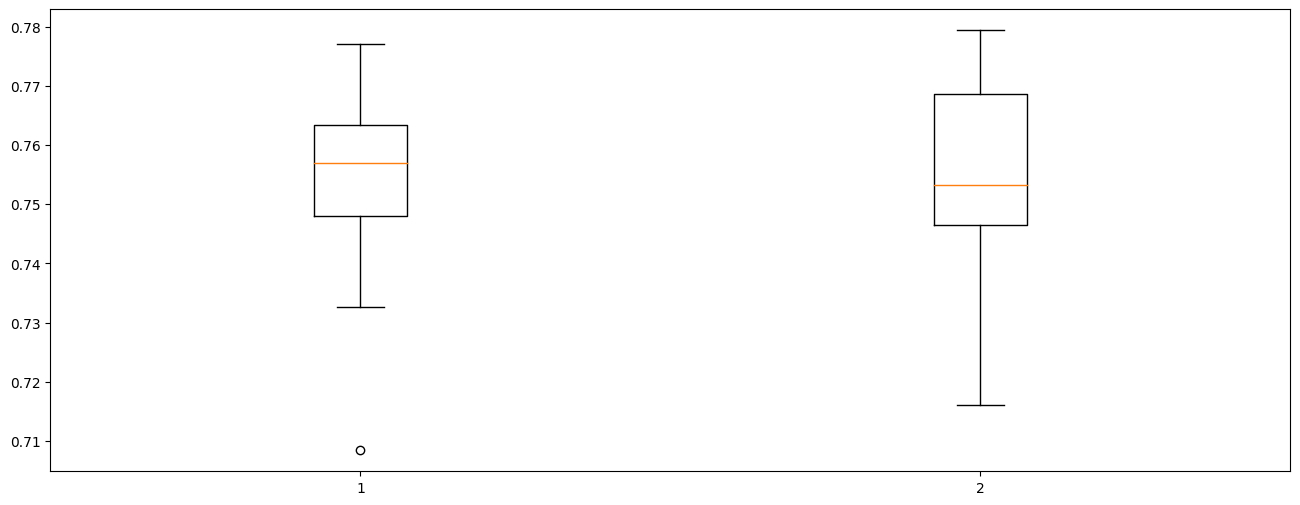

In [12]:
data = [[0.7576, 0.7548, 0.7656, 0.7673, 0.7643, 0.7327, 0.7634, 0.755, 0.777, 0.7601, 0.7634, 0.7084, 0.7424, 0.7344, 0.761, 0.7473, 0.7507, 0.7486, 0.757], [0.7294, 0.7517, 0.7709, 0.7478, 0.7223, 0.7761, 0.7539, 0.7684, 0.7484, 0.7161, 0.7314, 0.767, 0.7424, 0.7512, 0.7644, 0.7794, 0.76, 0.7694, 0.773, 0.7526]]
plt.figure(figsize = (16.,6.))
plt.boxplot(data)

In [17]:

t_stat, p_val = stats.ttest_ind(data[0], data[1])
print(p_val)


0.6869126142844695


Левый график - лучшая сеть по итогам прошлых экспериментов, справа - с батч нормализацией. Обычная сеть показала более высокие результаты


{'whiskers': [<matplotlib.lines.Line2D at 0x7b7056372710>,
 'caps': [<matplotlib.lines.Line2D at 0x7b7056372c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b7056372470>,
 'medians': [<matplotlib.lines.Line2D at 0x7b7056373190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7b7056373430>,
 'means': []}

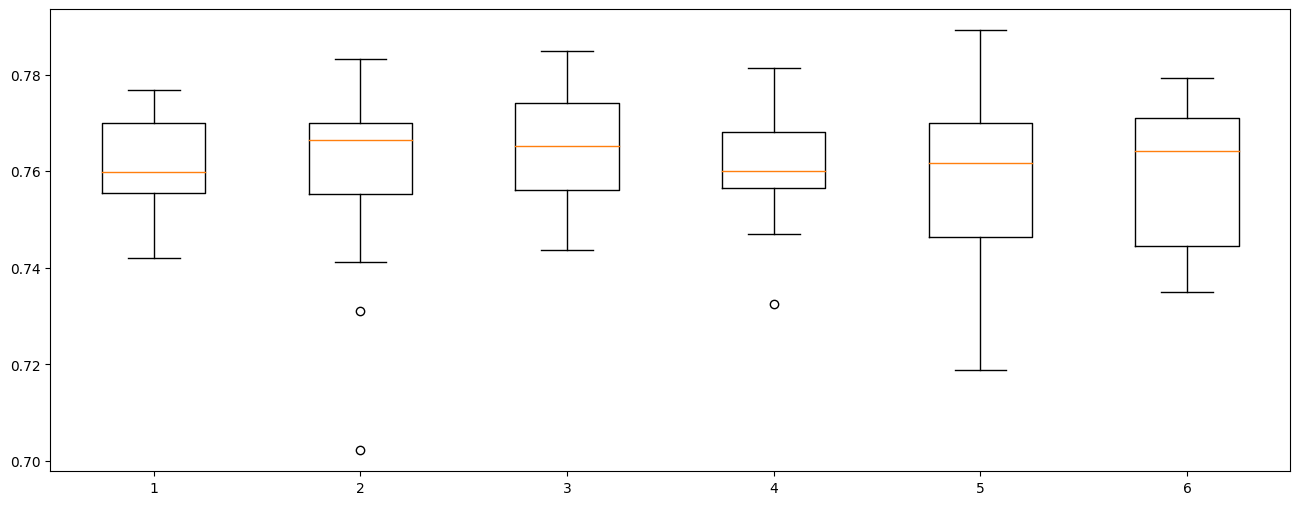

In [14]:
data = [[0.7574, 0.7725, 0.7719, 0.7696, 0.7594, 0.7461, 0.7599, 0.7554, 0.742, 0.7685, 0.749, 0.7705, 0.7769, 0.7554, 0.7615], [0.7771, 0.756, 0.7663, 0.7667, 0.7701, 0.7311, 0.7706, 0.7022, 0.7412, 0.7832, 0.762, 0.7696, 0.7688, 0.755], [0.7741, 0.7587, 0.785, 0.7746, 0.7816, 0.7585, 0.7534, 0.7458, 0.7436, 0.7688, 0.7652, 0.7663, 0.7562], [0.7609, 0.7471, 0.7708, 0.7565, 0.7567, 0.7632, 0.7704, 0.7593, 0.7814, 0.7669, 0.7583, 0.7685, 0.7326, 0.7545], [0.7628, 0.762, 0.7617, 0.7463, 0.7189, 0.7611, 0.77, 0.7721, 0.7574, 0.7198, 0.7892, 0.7359, 0.7751], [0.7659, 0.7603, 0.7393, 0.7445, 0.7741, 0.773, 0.771, 0.7556, 0.7641, 0.735, 0.7794, 0.7418, 0.7676]]
plt.figure(figsize = (16.,6.))
plt.boxplot(data)

In [24]:
t_stat, p_val = stats.ttest_ind(data[4], data[5])
print(p_val)


0.6740209354278605


График точности сети с дропаутом. Лучший результат для значения дропаута: 0.1 64 эпохи (2)


{'whiskers': [<matplotlib.lines.Line2D at 0x7b70150404c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b7015040a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b70150170d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7b7015040f40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7b70150411e0>,
 'means': []}

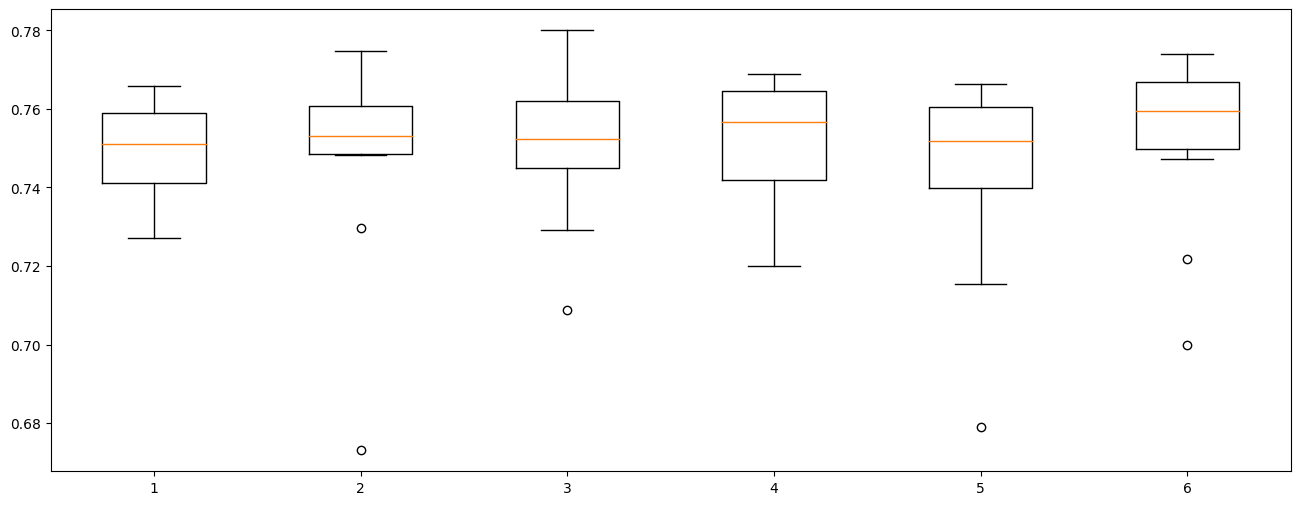

In [25]:
data = [[0.7592, 0.7406, 0.7578, 0.7649, 0.7286, 0.7577, 0.7271, 0.7444, 0.7429, 0.7657], [0.7597, 0.7483, 0.7738, 0.7533, 0.7748, 0.7611, 0.7496, 0.7528, 0.7297, 0.6731], [0.7469, 0.7645, 0.7482, 0.78, 0.7443, 0.7087, 0.7634, 0.7565, 0.7291, 0.7579], [0.7441, 0.7631, 0.751, 0.7358, 0.7199, 0.7688, 0.7413, 0.7625, 0.766, 0.7649], [0.7556, 0.7482, 0.7539, 0.6789, 0.7624, 0.7663, 0.7155, 0.7498, 0.737, 0.7621], [0.7218, 0.7604, 0.7656, 0.6998, 0.7571, 0.7472, 0.774, 0.7715, 0.7584, 0.7672]]
plt.figure(figsize = (16.,6.))
plt.boxplot(data)

График точности для сети с дропаутом и батч нормализацией. Лучший результат: 0.001, 27 эпох

{'whiskers': [<matplotlib.lines.Line2D at 0x7b7014eafee0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b7014eec340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b7014eafc40>,
 'medians': [<matplotlib.lines.Line2D at 0x7b7014eec880>,
 'fliers': [<matplotlib.lines.Line2D at 0x7b7014eecb20>,
 'means': []}

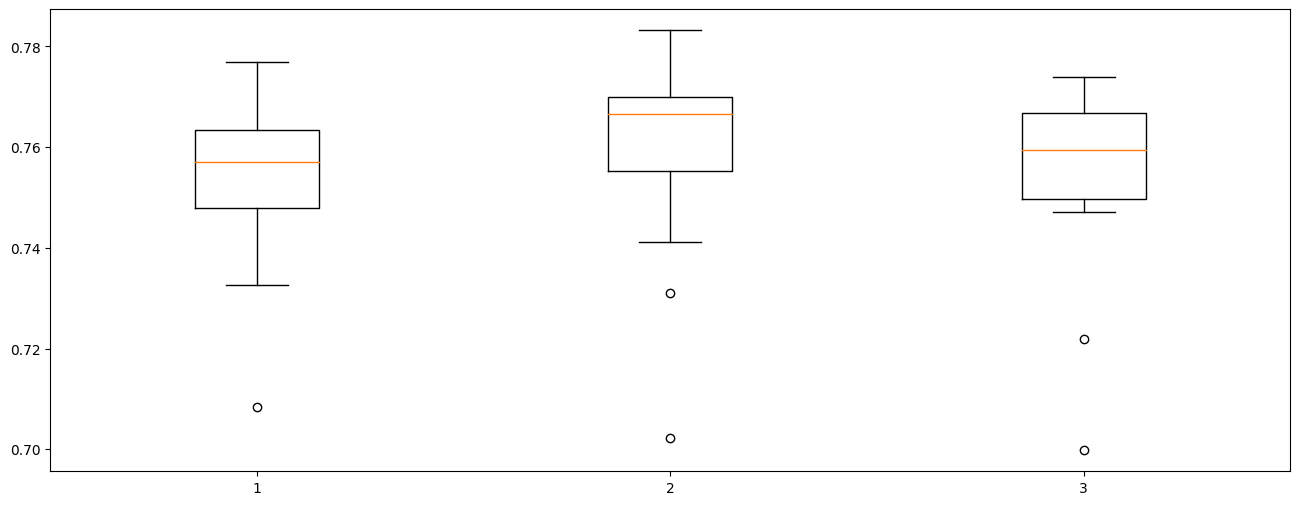

In [26]:
final_data = [[0.7576, 0.7548, 0.7656, 0.7673, 0.7643, 0.7327, 0.7634, 0.755, 0.777, 0.7601, 0.7634, 0.7084, 0.7424, 0.7344, 0.761, 0.7473, 0.7507, 0.7486, 0.757], [0.7771, 0.756, 0.7663, 0.7667, 0.7701, 0.7311, 0.7706, 0.7022, 0.7412, 0.7832, 0.762, 0.7696, 0.7688, 0.755] ,[0.7218, 0.7604, 0.7656, 0.6998, 0.7571, 0.7472, 0.774, 0.7715, 0.7584, 0.7672]]
plt.figure(figsize = (16.,6.))
plt.boxplot(final_data)

Лучшая сеть среди всех: сеть с дропаутом (2).

Парметры: dropout_rate = 0.1, 64 эпохи